##  sunburst and sankey visualization for squad question samples

It is advised to use sunburst for as it is interactive drill down enabled

In [1]:
import plotly.express as px
import pandas as pd
from plotly import graph_objects as go
import plotly

### get sample data

In [2]:
squad_json = pd.read_json('../data/squad_dev_v2.0.json')

In [3]:
normans = pd.Series([x['question'] for x in squad_json['data'][0]['paragraphs'][0]['qas']])

In [4]:
normans

0                 In what country is Normandy located?
1                   When were the Normans in Normandy?
2        From which countries did the Norse originate?
3                            Who was the Norse leader?
4    What century did the Normans first gain their ...
5    Who gave their name to Normandy in the 1000's ...
6                          What is France a region of?
7            Who did King Charles III swear fealty to?
8               When did the Frankish identity emerge?
dtype: object

In [5]:
normans_ls = normans.str.split(' ')

### Create functions for manipulating data and plotting

In [12]:
def expand_sentence(sentence, n ):
    sen = sentence.split(' ')
    dc = {}
    for i in range(n):
        dc[i] = sen[i]
    return dc

In [13]:
def expand_sentence_cols(ser, n=2):
    df = ser.apply(expand_sentence,n=n)
    return pd.DataFrame(list(df))

In [14]:
def plot_sentence_sunburst(ser, level=2):
    """
    ser: pandas series containing sentences as strings with words separated by single space
    level: the depth of sunburst plot in terms of words to be taken from beginning
    output: sunburst plot of words in sentences depicting their connections and frequency
    """
    df = expand_sentence_cols(ser, n=level)
    df = pd.DataFrame(df.groupby(list(range(level))).apply(len)).rename(columns={0:'count'}).reset_index()
    #return df
    fig = px.sunburst(df, path=list(range(level)), values='count')
    fig.show()

In [16]:
def get_layer_data(ser, n=2): # gets data  as value counts from the given layer from event_path # i.e the counts of n-1th and nth steps
    ser_x = ser.str.split(' ').map(lambda x: tuple(x[n-2:n]) if len(x)>=n else None)
    return pd.Series(ser_x).value_counts()
    
def get_all_indices(listlike, compare_value):
    return [i for i, value in enumerate(listlike) if value == compare_value] 

In [17]:
# creating a new class from go.Sankey
class Layered_sankey(go.Sankey):
    def add_first_layer(self, data_value_counts): # adds first layer from a value_counts dataframe
        #nodes
        old_labels = list(data_value_counts.index.map(lambda x: x[0]).drop_duplicates())
        updated_labels = list(list(data_value_counts.index.map(lambda x: x[0]).drop_duplicates()) #First Layer, no incoming connections
                          + list(data_value_counts.index.map(lambda x: x[1]).drop_duplicates()) # Second Layer, contains connections from first layer
                         )
        #links
        new_source = [] #getting the sources for links from the first element of indx pair
        new_target = [] #getting the target for links from the second element of indx pair
        new_value = [] #  changed here to avoid duplication
        sum_value = data_value_counts.sum()
        self['node']['label'] = updated_labels
        self['link']['source'] = new_source
        self['link']['target'] = new_target
        self['link']['value'] = new_value
        
        for s, t in data_value_counts.index:
            new_source.append(get_all_indices(old_labels, s)[-1])#appending source 
            new_target.append(get_all_indices(updated_labels, t)[-1])#appending target
            new_value.append(data_value_counts[(s,t)])#appending value
        self['node']['label'] = updated_labels
        self['link']['source'] = new_source
        self['link']['target'] = new_target
        self['link']['value'] = new_value
        self['link']['label'] = tuple(
            map(
                lambda x: str(round(x*100,4)) + ' %', list(data_value_counts/sum_value)
            )
        )

        
 
    
    def add_layer(self,data_value_counts): # adds a layer from value counts dataframe
        #nodes
        old_labels = list(self['node']['label'])
        new_labels = list(data_value_counts.index.map(lambda x: x[1]).drop_duplicates()) # add new layer nodes
        updated_labels = tuple(old_labels + new_labels)
        sum_value = data_value_counts.sum()
        #print (old_labels)
        #print(new_labels)
        #print(updated_labels)
        #links 
        new_source = list(self['link']['source'])
        new_target = list(self['link']['target'])
        new_value = list(self['link']['value'])
        new_label = list(self['link']['label'])
        
        for s, t in data_value_counts.index:
            new_source.append(get_all_indices(old_labels, s)[-1])#appending source 
            new_target.append(get_all_indices(updated_labels, t)[-1])#appending target
            new_value.append(data_value_counts[(s,t)])#appending value
            new_label.append(str(round(100*data_value_counts[(s,t)]/sum_value, 4)) + ' %')#appending label
            
        self['node']['label'] = tuple(updated_labels)
        self['link']['source'] = tuple(new_source)
        self['link']['target'] = tuple(new_target)
        self['link']['value'] = tuple(new_value)
        self['link']['label'] = tuple(new_label)

In [18]:
def plot_sentence_sankey(ser, level=2):
    #initialise the sankey using basic info
    fwd_sankey = Layered_sankey(
        node = dict(
          #pad = 15,
          #thickness = 20,
          #line = dict(color = "black", width = 0.5),
          #label = ["RedZone Purchase"],
          #color = "blue"
        ),
        link = dict(
        color = 'rgba(0,0,150,0.2)' # color of connections
        )
    )
    
    fwd_sankey.add_first_layer(get_layer_data(ser, 2))
    if level > 2:
        for i in range(3, level+1):
            fwd_sankey.add_layer(get_layer_data(ser, i))
    
    fig = go.Figure(data = fwd_sankey)
    fig.show()

### Plots

#### sunburst

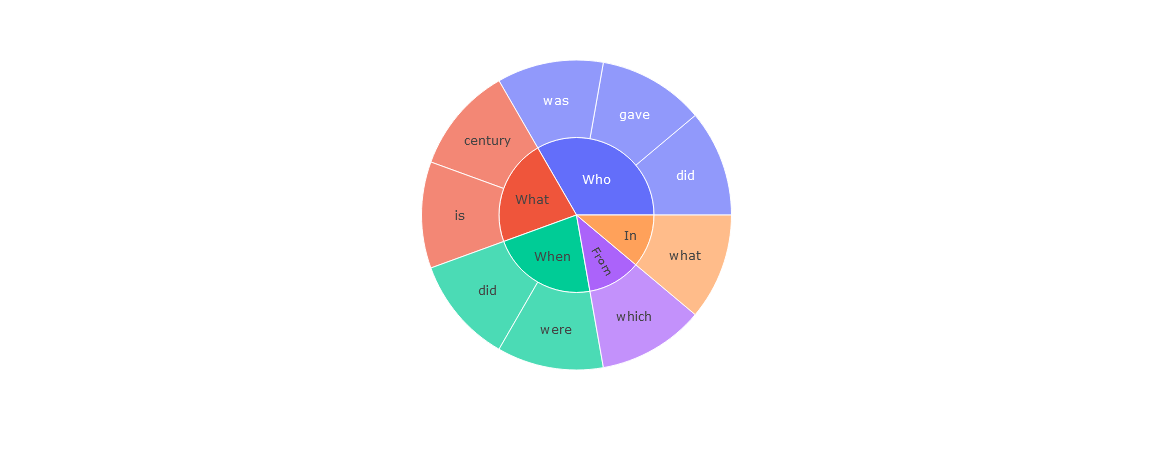

In [20]:
plot_sentence_sunburst(normans, 2)

In [22]:
questions2 = normans.append(pd.Series([x['question'] for x in squad_json['data'][1]['paragraphs'][0]['qas']]))

In [19]:
questions2

0                 In what country is Normandy located?
1                   When were the Normans in Normandy?
2        From which countries did the Norse originate?
3                            Who was the Norse leader?
4    What century did the Normans first gain their ...
5    Who gave their name to Normandy in the 1000's ...
6                          What is France a region of?
7            Who did King Charles III swear fealty to?
8               When did the Frankish identity emerge?
0    What branch of theoretical computer science de...
1    By what main attribute are computational probl...
2    What is the term for a task that generally len...
3          What is computational complexity principle?
4    What branch of theoretical computer class deal...
5    What is understood to be a task that is in pri...
6     What cannot be solved by mechanical applicati...
7    What is a manual application of mathematical s...
dtype: object

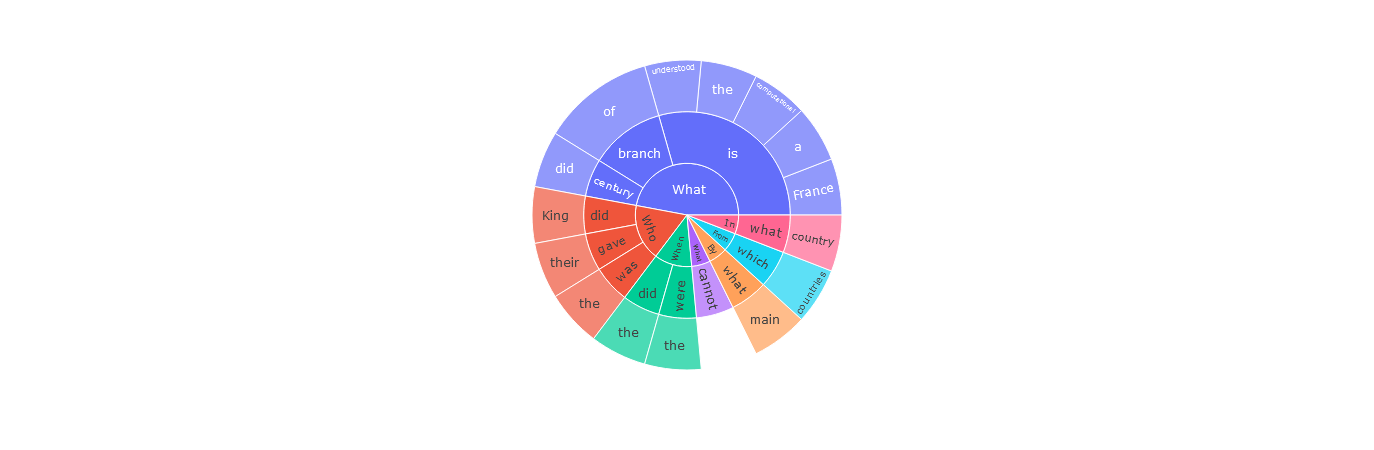

In [22]:
plot_sentence_sunburst(questions2,3)

In [23]:
questions3 = questions2.append(pd.Series([x['question'] for x in squad_json['data'][1]['paragraphs'][0]['qas']]))

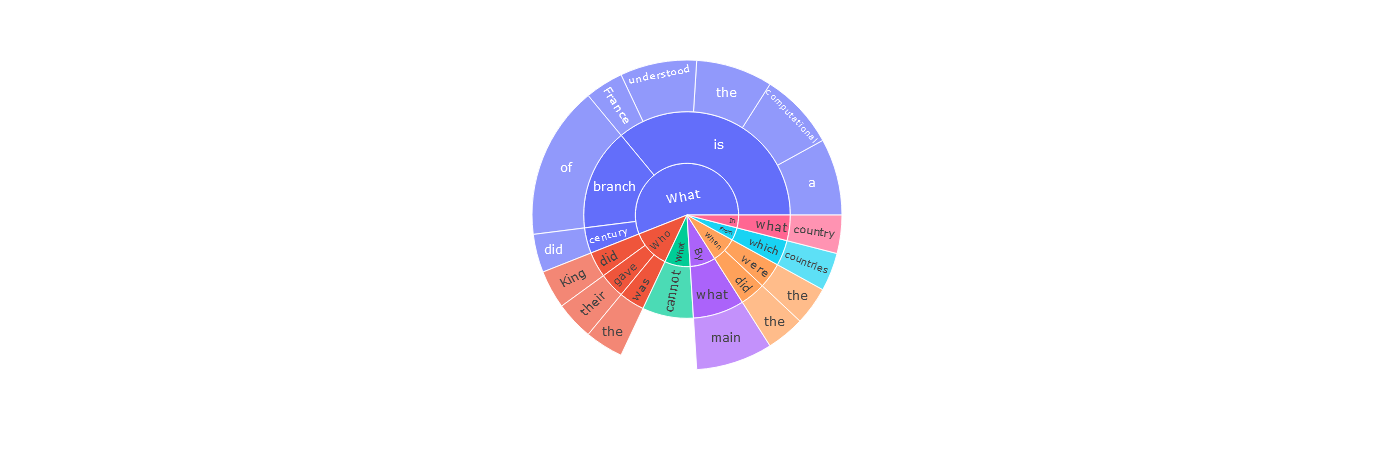

In [24]:
plot_sentence_sunburst(questions3,3)

#### Sankey

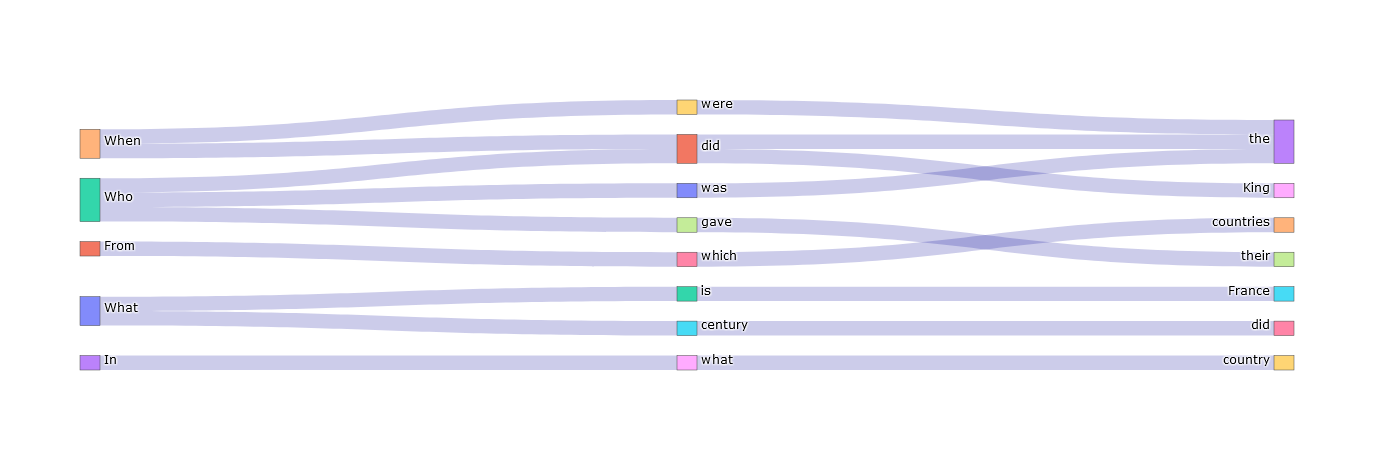

In [20]:
plot_sentence_sankey(normans, level=3)

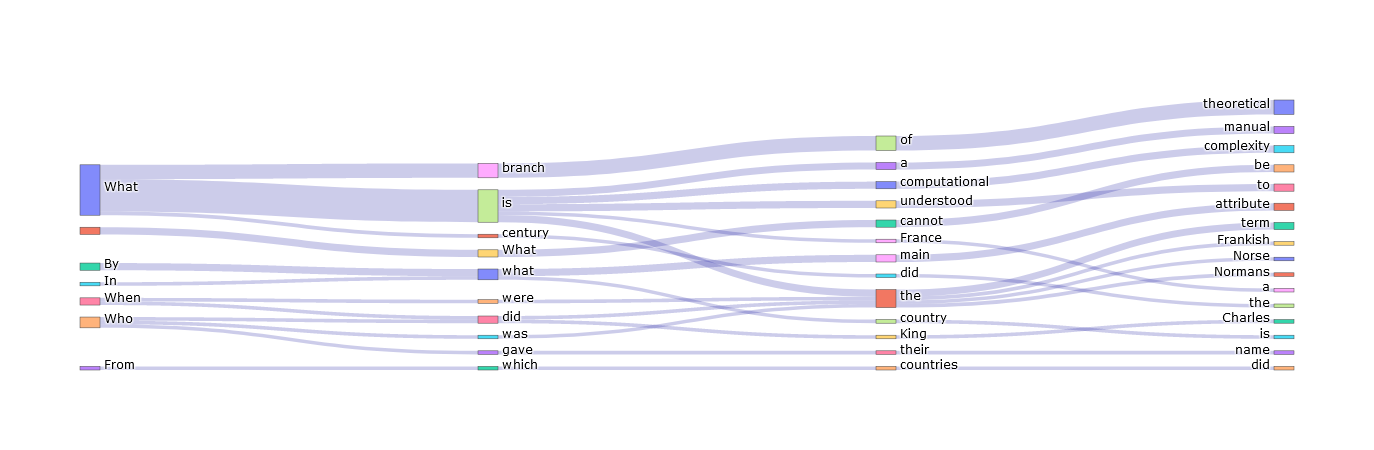

In [24]:
plot_sentence_sankey(questions3, level=4)